# Homework 2 - eCommerce analytics

*Authors:*
- _Tansel Simsek_
- _Andrea Carella_
- _Adrienn Timea Aszalos_

Date: 08.11.2020


## Introduction to the homework

<font size="2">E-commerce, also known as electronic commerce or internet commerce, refers to the buying and selling of goods or services using the internet, and the transfer of money and data to execute these transactions. The first e-commerce implementations date back to the 1990s and since then, millions of people every day visit some e-commerce sites to look for some product or service and, eventually, to purchase it.

You have been hired as a data scientist from a big multi-category online store. You and your team have been required to perform an analysis of the customer behavior in the store. Each row in the dataset represents an event, which catches different interactions (views, a product added/removed to/from the cart, purchases) of customers with your e-commerce. All events are related to products and users.

Your goal is to answer some research questions (RQs) that may help us discover and interpret meaningful patterns in data and eventually increase the number of sales.</font>

## Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm # ColorMap
import numpy as np
import gc # Garbage Collector
from collections import OrderedDict 
import datetime

## Importing datasets

<font size="3">**NOTE!!!** 
    The _**category_code**_  and _**brand**_ columns of the dataset may have missing values.</font>

In [20]:
# Reclaiming the maximum amount of available memory
gc.collect()

# Importing the file 2019-Oct.csv and converting the values of the column "event_time" from string to type datetime64

dataset = pd.read_csv('./data/2019-Oct.csv', 
                      header='infer', 
                      parse_dates=['event_time'],
                     date_parser=pd.to_datetime, nrows=90000)

In [21]:
# Reclaiming the maximum amount of available memory
gc.collect()

# Importing the file 2019-Nov.csv and converting the values of the column "event_time" from string to timestamp

dataset_nov = pd.read_csv('./data/2019-Nov.csv', 
                      header='infer', 
                      parse_dates=['event_time'],
                     date_parser=pd.to_datetime, nrows=90000)

In [22]:
# Reclaiming the maximum amount of available memory
gc.collect()

# Merging the two datasets into one single dataset and storing the final data into an existing variable in order 
# to use as little memory as possible
dataset = dataset.append(dataset_nov).reset_index()

# Deleting the unused variable in order to free memory space
del dataset_nov

In [23]:
# Reclaiming the maximum amount of available memory
gc.collect()

# Storing the data into a pickle file in order to procees it more rapidly instead of processing the two csv files each time 
# we start the session in Jupiter
dataset.to_pickle("data/mergedata")

In [2]:
# Reclaiming the maximum amount of available memory
gc.collect()

# Reading the picked merged file that contains Oct and Nov 2019 datasets
dataset = pd.read_pickle("data/mergedata")

## Let's visualize and know our dataset

Viewing the structure of the dataset

In [25]:
dataset.head()

,index,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,0,2019-10-01 00:00:00+00:00,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,1,2019-10-01 00:00:00+00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2,2019-10-01 00:00:01+00:00,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,3,2019-10-01 00:00:01+00:00,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,4,2019-10-01 00:00:04+00:00,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


The columns of our dataset are the following:
- _event_time:_ Time when event happened at (in UTC).
- _event_type:_
    
    Events can be:

    - view - a user viewed a product
    - cart - a user added a product to shopping cart
    - removefromcart - a user removed a product from shopping cart
    - purchase - a user purchased a product

    Typical funnel: view => cart => purchase.
    

- _product_id:_ ID of a product
- _category_id:_ Product's category ID
- _category_code:_ Product's category taxonomy (code name) if it was possible to make it. Usually present for meaningful categories and skipped for different kinds of accessories.
- _brand:_ Downcased string of brand name. Can be missed. 
- _price:_ Float price of a product. Present.
- _user_id:_ Permanent user ID.
- _user_session:_ Temporary user's session ID. Same for each user's session. Is changed every time user come back to online store from a long pause.

**NOTE!!!** 
- The columns:
    - **_brand_**,
    - _**category_code**_ may **contain missing values**
- The value **_removefromcart_** of the column *event_type* **is missing**.

In [26]:
dataset.columns

Index(['index', 'event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

In [27]:
print('The dataset is composed of ' + str(dataset.shape[0]) + ' rows and ' + str(dataset.shape[1]) + ' columns.')

The dataset is composed of 180000 rows and 10 columns.


## Generating a descriptive statistics about the dataframe:

In [28]:
dataset.describe(datetime_is_numeric=True, include='all')

,index,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
count,180000.000000,180000,180000,1.800000e+05,1.800000e+05,120390,152780,180000.000000,1.800000e+05,180000
unique,NaN,NaN,3,NaN,NaN,126,1935,NaN,NaN,44479
top,NaN,NaN,view,NaN,NaN,electronics.smartphone,samsung,NaN,NaN,dab9fcec-5ecd-428a-914d-d60f3f73d32c
freq,NaN,NaN,175313,NaN,NaN,46501,21021,NaN,NaN,107
mean,44999.500000,2019-10-16 14:54:57.393001472+00:00,NaN,1.080940e+07,2.057020e+18,NaN,NaN,284.861821,5.332905e+08,NaN
min,0.000000,2019-10-01 00:00:00+00:00,NaN,1.001588e+06,2.053014e+18,NaN,NaN,0.000000,2.752567e+08,NaN
25%,22499.750000,2019-10-01 03:26:46+00:00,NaN,1.005203e+06,2.053014e+18,NaN,NaN,64.020000,5.157841e+08,NaN
50%,44999.500000,2019-10-16 14:08:57+00:00,NaN,5.100852e+06,2.053014e+18,NaN,NaN,159.850000,5.293604e+08,NaN
75%,67499.250000,2019-11-01 02:39:59+00:00,NaN,1.630011e+07,2.053014e+18,NaN,NaN,352.150000,5.509919e+08,NaN
max,89999.000000,2019-11-01 03:41:25+00:00,NaN,6.050000e+07,2.180737e+18,NaN,NaN,2574.070000,5.663080e+08,NaN


## Managing missing data values

In [29]:
print('There are ' + str(dataset['brand'].isnull().sum()) + ' rows that present missing values in the column brand.')

There are 27220 rows that present missing values in the column brand.


In [30]:
print('There are ' + str(dataset['category_code'].isnull().sum()) + ' rows that present missing values in the column category_code.')

There are 59610 rows that present missing values in the column category_code.


In [31]:
print('The total number of the rows containing missing values is: ' + str(dataset.isnull().any(axis=1).sum()) + '.')

The total number of the rows containing missing values is: 70614.


In [32]:
print('The percentage of missing value in the original dataset is: ' + str(round(dataset.isnull().any(axis=1).sum()/len(dataset),2)) + '%.')

The percentage of missing value in the original dataset is: 0.39%.


**Why did we chose to maintain the NaN values**

Since the less populated values are the ones of the attributes *category_code* and *brand* we opt to maintain the missing values (NaN) without replacing them or filling them with other values, because it doesn't make much sense to impute values for a category code or/and a brand name.

If we would have performed machine learning techniques then in that case we would have filled in the missing values.
Also we excluded the removal of the missing data because the percentage of it was very high (see cell above).

## Research questions

### [RQ1] 

**INTRO**

A marketing funnel describes your customer’s journey with your e-commerce. It may involve different stages, beginning when someone learns about your business, when he/she visits your website for the first time, to the purchasing stage, marketing funnels map routes to conversion and beyond. Suppose your funnel involves just three simple steps: 1) view, 2) cart, 3) purchase. 

### [RQ1.0] 
Which is the rate of complete funnels?


In [35]:
# Reclaiming the maximum amount of available memory
gc.collect()

# Group dataset by product_id, user_session and event_type and count the occurrences of each event type
completeFunnel = dataset.groupby(['product_id', 'user_session', 'event_type']).event_type.count()

# Reclaiming the maximum amount of available memory
gc.collect()

# Convert obtained GroupBy Series into a Dataframe in order to rename the name of the column 
# containing the occurrences for each event type
completeFunnel = pd.DataFrame(completeFunnel).rename(columns={'event_type':'count'}).reset_index()

# Reclaiming the maximum amount of available memory
gc.collect()

# Group dataset by product_id and user_session and count the occurrences of each user session 
completeFunnel = completeFunnel.groupby(['product_id','user_session']).user_session.count()

# Reclaiming the maximum amount of available memory
gc.collect()

# Convert obtained GroupBy Series into a Dataframe in order to rename the name of the column 
# containing the occurrences for each user session
completeFunnel = pd.DataFrame(completeFunnel).rename(columns={'user_session':'count'}).reset_index()

# Total number of rows containing the occurrences of each user session
N = int(completeFunnel.shape[0])

# Number of all the rowss containing all the three steps (view, cart, purchase) per session
n = completeFunnel[completeFunnel['count'] == 3].shape[0]

# Reclaiming the maximum amount of available memory
gc.collect()

# Calculate the rate of complete funnels 
completeFunnelRate = round(n*100/N)

print("The complete funnel rate is:", str(completeFunnelRate) + '%')

# Deleting variables to free RAM
del completeFunnel, N, n, completeFunnelRate

The complete funnel rate is: 1%


### [RQ1.1]

What’s the operation users repeat more on average within a session? Produce a plot that shows the average number of times users perform each operation (view/removefromchart etc etc).

From the plot we can deduce the following informations:

1. The most repetead operation is: view.
2. The average number of cart operations per session is: 0.04
3. The average number of purchase operations per session is: 0.06
4. The average number of view operations per session is: 3.94
5. The average number of removefromcart operations per session is: 0


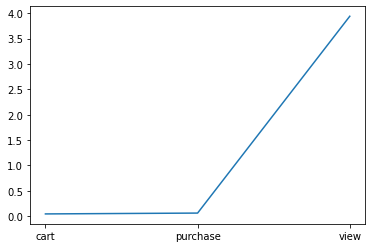

In [36]:
# Reclaiming the maximum amount of available memory
gc.collect()

# Grouping the data by the event types and counting the number of occurrences for each event:
totalOperationsPerEventType = dataset.groupby('event_type').event_type.count()

# Reclaiming the maximum amount of available memory
gc.collect()

# Converting the dataset into an array and dividing each element of the array by the total unique numbers of sessions
# in order to obtain the average number of operations per event type
averageNumberOfOperationsPerSession = totalOperationsPerEventType.to_numpy()/dataset.user_session.nunique()

# Reclaiming the maximum amount of available memory
gc.collect()

# Getting the unique names of the event types 
eventTypes = sorted(dataset.event_type.unique())

# Plotting the average number of times users perform each operation (view/removefromchart etc etc)
plt.plot(eventTypes,averageNumberOfOperationsPerSession)

print("From the plot we can deduce the following informations:" + '\n')
print("1. The most repetead operation is:", str(eventTypes[len(eventTypes)-1]) + ".")
print("2. The average number of cart operations per session is: " + str(round(averageNumberOfOperationsPerSession[0],2)))
print("3. The average number of purchase operations per session is: " + str(round(averageNumberOfOperationsPerSession[1],2)))
print("4. The average number of view operations per session is: " + str(round(averageNumberOfOperationsPerSession[2],2)))
print("5. The average number of removefromcart operations per session is: " + str(0))

del totalOperationsPerEventType, averageNumberOfOperationsPerSession, eventTypes

### [RQ1.2]

How many times, on average, a user views a product before adding it to the cart?

In [38]:
# Reclaiming the maximum amount of available memory
gc.collect()

# Creating a new dataframe with grouping the data by user_id, user_session, product_id and counting the number of occurrences for event_type "view":
view_df = dataset.groupby([dataset.user_id, dataset.user_session, dataset.product_id, dataset[dataset.event_type=='view'].event_type]).event_type.count()

# Reclaiming the maximum amount of available memory
gc.collect()

# Creating a new dataframe with grouping the data by user_id, user_session, product_id and counting the number of occurrences for event_type "cart":
cart_df = dataset.groupby([dataset.user_id, dataset.user_session, dataset.product_id, dataset[dataset.event_type=='cart'].event_type]).event_type.count()

# Reclaiming the maximum amount of available memory
gc.collect()

# Merging view_df and cart_df based on the same features which are user_id, user_session and product_id
view_cart_df = pd.merge(view_df, cart_df, how ='inner', on =['user_id', 'user_session', 'product_id'])

# Reclaiming the maximum amount of available memory
gc.collect()

# Finding the average number of views of a product before added to the cart
average_view_before_cart = view_cart_df.event_type_x.sum()/view_cart_df.event_type_y.sum()

print("Average of " + str(average_view_before_cart) + " times user views product before adding it to the cart.")

# Delete variable to free RAM
del view_df
del view_cart_df
del average_view_before_cart

Average of 1.7735562310030395 times user views product before adding it to the cart.


### [RQ1.3]
What’s the probability that products added once to the cart are effectively bought?

In [39]:
# Reclaiming the maximum amount of available memory
gc.collect()

# Creating a new dataframe with grouping the data by user_id, user_session, product_id and counting the number of occurrences for event_type "purchase":
purchase_df = dataset.groupby([dataset.user_id, dataset.user_session, dataset.product_id, dataset[dataset.event_type=='purchase'].event_type]).event_type.count()

# Reclaiming the maximum amount of available memory
gc.collect()

# Merging purchase_df and cart_df based on the same features which are user_id, user_session and product_id
# cart_df is created at RQ1.2
purchase_cart_df = pd.merge(purchase_df, cart_df, how ='inner', on =['user_id', 'user_session', 'product_id'])

# Reclaiming the maximum amount of available memory
gc.collect()

# Finding probability of the products that added to the card once are effectively bought
# Can be found as intersection of the bought and added to cart products over added to cart products based on the same user_session, user_id and product_id
probability_bought_given_added_to_cart = len(purchase_cart_df)/len(cart_df)

print("Probability of the products added once to the cart that are effectively bought is: " + str(probability_bought_given_added_to_cart))

# Delete variable to free RAM
del purchase_df
del purchase_cart_df
del probability_bought_given_added_to_cart
del cart_df

Probability of the products added once to the cart that are effectively bought is: 0.5146443514644351


### [RQ1.4]
What’s the average time an item stays in the cart before being removed?

### NOTE!!!
Since the dataset doesn't contain any removefromcart event type value, we will solve the exercise considering that a product item is removed from the cart when purchased. 

In [44]:
# Reclaiming the maximum amount of available memory
gc.collect()

# Select the rows containing the products added to the cart
productsAddedToCart = dataset[dataset.event_type == 'cart'].rename(columns={'event_time':'timestamp_cart', 'event_type':'cart_event'})

# Reclaiming the maximum amount of available memory
gc.collect()

# Select the rows containing the purchased products 
purchasedProducts = dataset[dataset.event_type == 'purchase'].rename(columns={'event_time':'timestamp_purchase', 'event_type':'purchase_event'})

# Reclaiming the maximum amount of available memory
gc.collect()

# Removing unuseful columns from the table containing the products added to the cart
productsAddedToCart = productsAddedToCart.drop(columns = ['index', 'category_id', 'category_id', 'category_code', 'brand', \
                                  'price', 'user_id', 'user_session'])

# Reclaiming the maximum amount of available memory
gc.collect()

# Removing unuseful columns from the table containing the purchased products
purchasedProducts = purchasedProducts.drop(columns = ['index', 'category_id', 'category_id', 'category_code', 'brand', \
                                  'price', 'user_id', 'user_session'])

# Reclaiming the maximum amount of available memory
gc.collect()

# Merging the two tables on the column product_id
cartAndPurchased = productsAddedToCart.merge(purchasedProducts, on=['product_id'])

# Reclaiming the maximum amount of available memory
gc.collect()

# Calculating the absolute difference between the two timestamp values: 
# time when the product was added to the cart and time when the product has been bought.
# At last we convert the time in seconds
cartAndPurchased['timestamp_difference'] = (abs(cartAndPurchased['timestamp_purchase'] - cartAndPurchased['timestamp_cart'])).\
                                            astype('timedelta64[s]')

# Reclaiming the maximum amount of available memory
gc.collect()

# Calculating the mean time of purchase for each products and renaming the column and converting the serie in a dataframe 
cartAndPurchased = pd.DataFrame(cartAndPurchased.groupby(cartAndPurchased.product_id).\
                                timestamp_difference.mean()).\
                                rename(columns={'timestamp_difference':'average_purchase_time'}).\
                                reset_index()

# Reclaiming the maximum amount of available memory
gc.collect()

# Getting the average time of purchase of the products in seconds
sec = round(cartAndPurchased['average_purchase_time'].mean(),0)

print('The average time an item stays in the cart before being removed is:')
str(datetime.timedelta(seconds = sec))

The average time an item stays in the cart before being removed is:


'8 days, 10:59:08'

In [45]:
# Deleting unused variables of the previous exercise to free RAM 
del productsAddedToCart, purchasedProducts, cartAndPurchased, sec

### [RQ1.5]

How much time passes on average between the first view time and a purchase/addition to cart?

In [46]:
# Reclaiming the maximum amount of available memory
gc.collect()

# Creating a new dataframe by taking rows with event_type view
first_view_df = dataset[dataset.event_type=='view']

# Taking the first observed view event type for specific user_session, user_id and product_id
first_view_df = first_view_df.groupby(['user_session', 'user_id','product_id']).first()

# Reclaiming the maximum amount of available memory
gc.collect()

# Creating a new dataframe by tahing rows with event_type cart
cart_df = dataset[dataset.event_type=='cart']

# Reclaiming the maximum amount of available memory
gc.collect()

# Creating a new dataframe by tahing rows with event_type purchase
purchase_df = dataset[dataset.event_type=='purchase']

# Reclaiming the maximum amount of available memory
gc.collect()

# Constructing a new dataframe with using first_view_df and cart_df dataframes
# based on the same user_session, user_id, and product_id
time_elapse_between_first_view_and_cart_events=pd.merge(first_view_df, cart_df, how ='inner', on =['user_session', 'user_id', 'product_id'])

# Adding a new column in time_elapse_between_first_view_and_cart_events dataframe 
# to show time elapse between view event_type and cart event_type
time_elapse_between_first_view_and_cart_events['time_elapse']=time_elapse_between_first_view_and_cart_events.event_time_y-time_elapse_between_first_view_and_cart_events.event_time_x

# Reclaiming the maximum amount of available memory
gc.collect()

# Summing the time_elapse values to reach the average value and keeping the number of instances in the dataframe
total_time_elapse_between_first_view_and_cart_events = time_elapse_between_first_view_and_cart_events.time_elapse.sum()
count_total_time_elapse_between_first_view_and_cart_events = len(time_elapse_between_first_view_and_cart_events)

gc.collect()

# Constructing a new dataframe with using first_view_df and purchase_df dataframes
# based on the same user_session, user_id, and product_id
time_elapse_between_first_view_and_purchase_events=pd.merge(first_view_df, purchase_df, how ='inner', on =['user_session', 'user_id', 'product_id'])

# Adding a new column in time_elapse_between_first_view_and_purchase_events dataframe 
# to show time elapse between view event_type and purchase event_type
time_elapse_between_first_view_and_purchase_events['time_elapse']=time_elapse_between_first_view_and_purchase_events.event_time_y-time_elapse_between_first_view_and_purchase_events.event_time_x

# Reclaiming the maximum amount of available memory
gc.collect()

# Summing the time_elapse values to reach the average value and keeping the number of instances in the dataframe
total_time_elapse_between_first_view_and_purchase_events = time_elapse_between_first_view_and_purchase_events.time_elapse.sum()
count_total_time_elapse_between_first_view_and_purchase_events = len(time_elapse_between_first_view_and_purchase_events)

gc.collect()

# Calculating the average time elapse between view and purchase/cart event_types
average_time_passes_between_first_view_and_purchase_or_cart_events = (total_time_elapse_between_first_view_and_cart_events + total_time_elapse_between_first_view_and_purchase_events)
average_time_passes_between_first_view_and_purchase_or_cart_events = average_time_passes_between_first_view_and_purchase_or_cart_events /(count_total_time_elapse_between_first_view_and_cart_events + count_total_time_elapse_between_first_view_and_purchase_events)

print('Average time passes on average between the first view and a purchase or cart events is: '+ str(average_time_passes_between_first_view_and_purchase_or_cart_events))

# Delete variable to free RAM
del first_view_df
del cart_df
del purchase_df
del time_elapse_between_first_view_and_cart_events
del total_time_elapse_between_first_view_and_cart_events
del count_total_time_elapse_between_first_view_and_cart_events
del time_elapse_between_first_view_and_purchase_events
del total_time_elapse_between_first_view_and_purchase_events
del count_total_time_elapse_between_first_view_and_purchase_events
del average_time_passes_between_first_view_and_purchase_or_cart_events


Average time passes on average between the first view and a purchase or cart events is: 0 days 00:03:19.638912671


### [RQ2.0] 

What are the categories of the most trending products overall? For each month visualize this information through a plot showing the number of sold products per category. 

The most 10 popular products overall with category_code and amount sold informations' are: 
-----------------------------------------------------------------------------------
category_code                product_id
electronics.smartphone       1004856       111
                             1004767        83
                             1002544        65
                             1005115        50
                             1004833        48
                             1004870        40
electronics.audio.headphone  4804056        40
electronics.smartphone       1004249        32
                             1005105        29
                             1004873        28
Name: product_id, dtype: int64


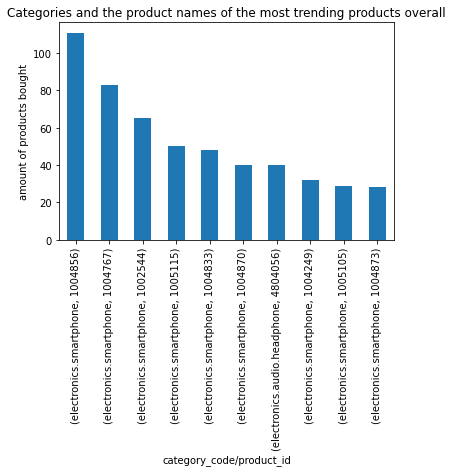

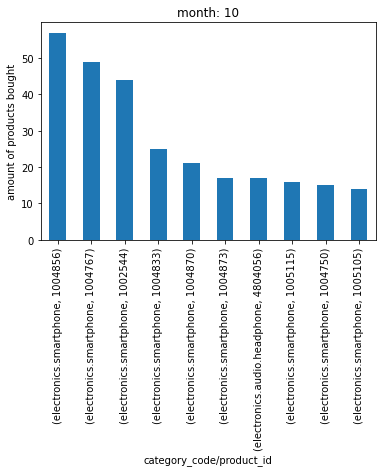

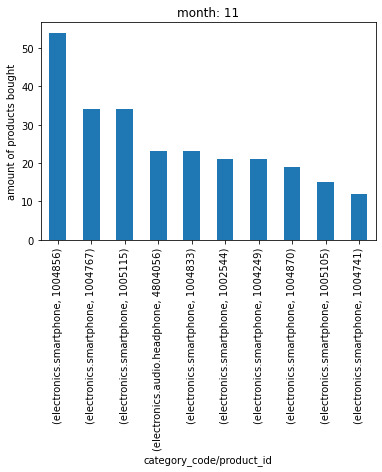

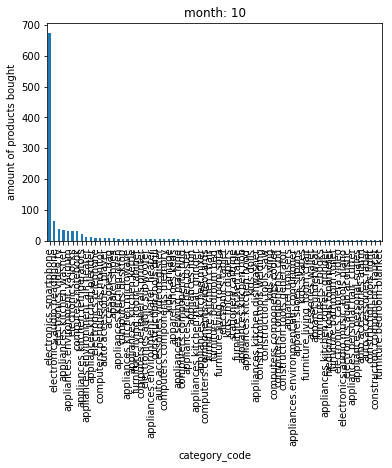

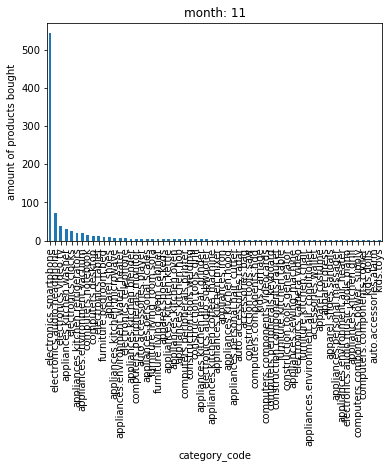

In [47]:
# Reclaiming the maximum amount of available memory
gc.collect()

# Creating a new dataframe with grouping the data by category_code and product_id in order to find the category of the most trending products sorted in descending order
categories_of_most_trending_products = dataset[dataset.event_type == 'purchase'].groupby(['category_code', 'product_id']).product_id.count().sort_values(ascending=False)

# Listing the most 10 popular products with category_code and amount sold information
print("The most 10 popular products overall with category_code and amount sold informations' are: ")
print("-----------------------------------------------------------------------------------")
print(categories_of_most_trending_products.head(10))

# Visualising the most 10 popular products with category_code and amount sold information
plt.figure()
categories_of_most_trending_products.head(10).plot.bar()
plt.title('Categories and the product names of the most trending products overall')
plt.xlabel('category_code/product_id')
plt.ylabel('amount of products bought')
plt.show()

# Reclaiming the maximum amount of available memory
gc.collect()

# Finding the unique months in the dataset to visualise month specific popular products and category information
unique_months_in_dataset=dataset.event_time.dt.month.unique()

# Creating new dataframe for each month and implementing the same code as above 
for i in range(len(unique_months_in_dataset)):
    new_df=dataset[dataset.event_time.dt.month==unique_months_in_dataset[i]]
    popular_products = new_df[new_df.event_type == 'purchase'].groupby(['category_code', 'product_id']).product_id.count().sort_values(ascending=False)
    plt.figure()
    popular_products.head(10).plot.bar()
    plt.title('month: '+str(unique_months_in_dataset[i]))
    plt.xlabel('category_code/product_id')
    plt.ylabel('amount of products bought')

    plt.show()
    
# Creating new dataframe for each month and visualising the number of products bought per category
for i in range(len(unique_months_in_dataset)):
    new_df=dataset[dataset.event_time.dt.month==unique_months_in_dataset[i]]
    popular_products = new_df[new_df.event_type == 'purchase'].groupby('category_code').event_type.count().sort_values(ascending=False)
    plt.figure()
    popular_products.plot.bar()
    plt.title('month: '+str(unique_months_in_dataset[i]))
    plt.xlabel('category_code')
    plt.ylabel('amount of products bought')
    plt.show()

# Delete variable to free RAM
del categories_of_most_trending_products
del unique_months_in_dataset

### [RQ2.1] 

Plot the most visited subcategories.

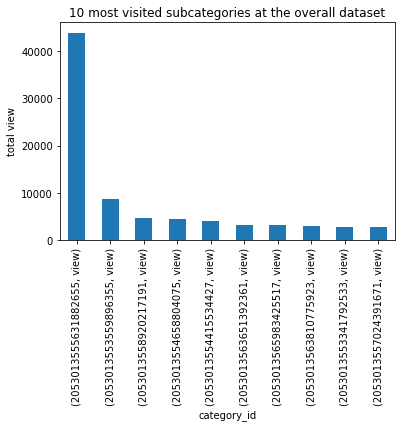

In [48]:
# Reclaiming the maximum amount of available memory
gc.collect()

# Creating new dataframe based on view event type and grouping by category_id to find the most popular subcategory
# Sorting in descending order
most_visited_subcategories = dataset[dataset.event_type == 'view'].groupby(["category_id", "event_type"]).event_type.count().sort_values(ascending=False)

# Visualising the bar plot of the most visited 10 subcategory
plt.figure()
most_visited_subcategories.head(10).plot.bar()
plt.title('10 most visited subcategories at the overall dataset')
plt.xlabel('category_id')
plt.ylabel('total view')
plt.show()

# Delete variable to free RAM
del most_visited_subcategories

### [RQ2.2] 

What are the 10 most sold products per category?

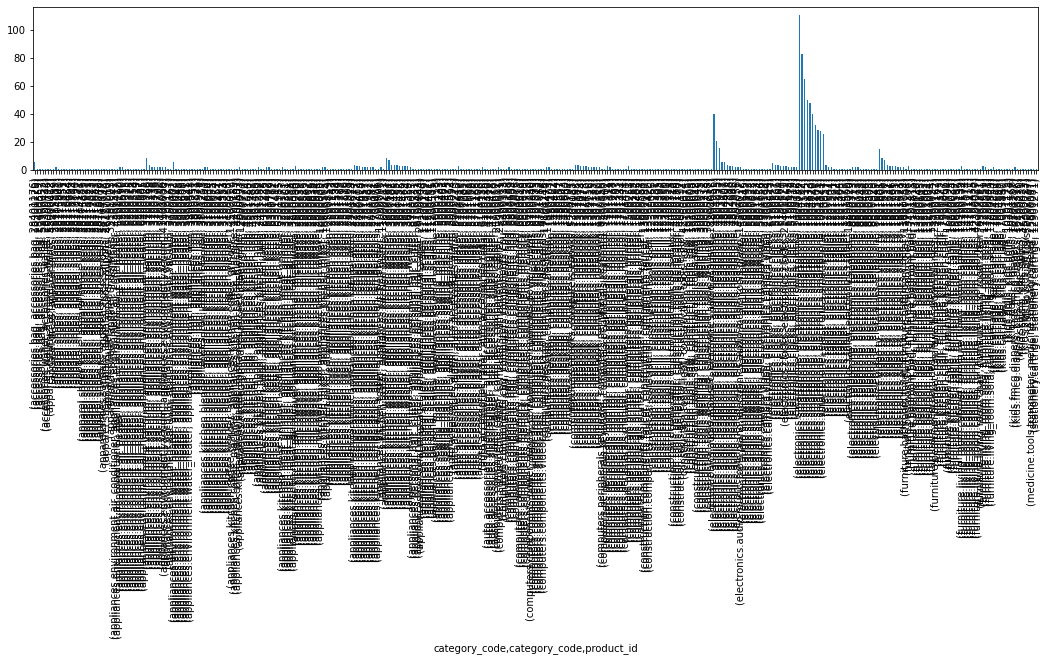

In [49]:
# Reclaiming the maximum amount of available memory
gc.collect()

# Creating a dataframe event_type only purchase and grouping by category_code and product_id to extract the number of products sold per category
ten_most_sold = dataset[dataset.event_type=='purchase'].groupby(['category_code', 'product_id']).product_id.count()

# Reclaiming the maximum amount of available memory
gc.collect()

# Because of the not sorted number of products per category, the following line reaches top 10 values 
ten_most_sold = ten_most_sold.groupby('category_code').nlargest(10)

# Visualising the 10 most sold products per category
ten_most_sold.plot.bar(figsize=(18,3))

# Delete variable to free RAM
del ten_most_sold

### [RQ3.0] 

For each category, what’s the brand whose prices are higher on average?

In [50]:
# Reclaiming the maximum amount of available memory
gc.collect()

# Creating a new dataframe with notnull value of price, grouping by category_code and brand, taking the mean value of the products' price for each brand
highest_price_brand_per_category = dataset[dataset.price.notnull()].groupby(["category_code", "brand"]).price.mean()

# Reclaiming the maximum amount of available memory
gc.collect()

# Grouping the created dataframe by category_code in order to find the highest mean value of the price
highest_price_brand_per_category = highest_price_brand_per_category.groupby('category_code').nlargest(1)

# Printing the final result
print(highest_price_brand_per_category)

# Delete variable to free RAM
del highest_price_brand_per_category

category_code         category_code         brand      
accessories.bag       accessories.bag       coccinelle      264.560000
accessories.umbrella  accessories.umbrella  hoco             25.710000
accessories.wallet    accessories.wallet    picard           68.150952
apparel.belt          apparel.belt          bond             23.170000
apparel.costume       apparel.costume       daneildesch     193.055000
                                                              ...     
sport.ski             sport.ski             salomon         514.556667
sport.snowboard       sport.snowboard       burton          280.315000
sport.tennis          sport.tennis          head            102.960000
sport.trainer         sport.trainer         shua           1754.325000
stationery.cartrige   stationery.cartrige   samsung          53.030000
Name: price, Length: 125, dtype: float64


### [RQ3.1] 

Write a function that asks the user a category in input and returns a plot indicating the average price of the products sold by the brand.

Please write a category name to have a plot of average price of products of this category
accessories.bag


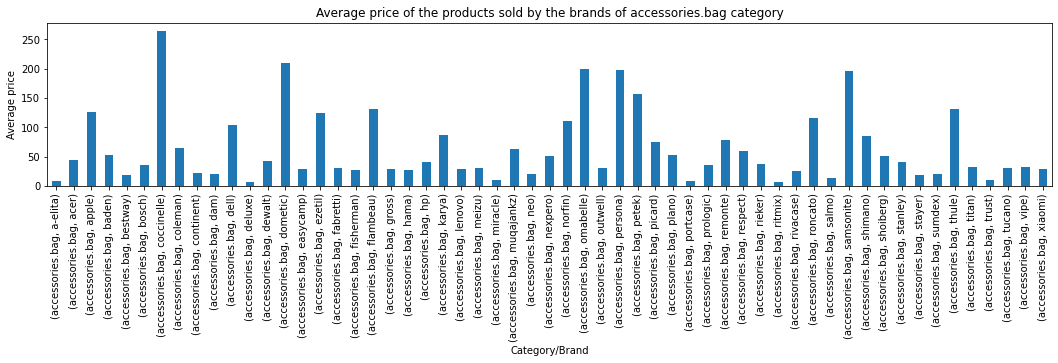

In [51]:
# Reclaiming the maximum amount of available memory
gc.collect()

# Taking the user input of category name (example: accessories.bag)
if __name__ =='__main__':
    print('Please write a category name to have a plot of average price of products of this category')
    cat_cod=str(input())

# Reclaiming the maximum amount of available memory
gc.collect()

# Eliminating null values of price
not_null_prices=dataset[dataset.price.notnull()]

# Reclaiming the maximum amount of available memory
gc.collect()

# Creating a new dataframe which has category_code entered by user, grouping by category_code and brand and taking the mean value
avg_price_of_products_brands_category= not_null_prices[not_null_prices.category_code==cat_cod].groupby(['category_code', 'brand']).price.mean()

# Plotting the average price of the products sold by the brand in user specified category
plt.figure()
avg_price_of_products_brands_category.plot.bar(figsize=(18,3))
plt.title('Average price of the products sold by the brands of '+ cat_cod + ' category')
plt.xlabel('Category/Brand')
plt.ylabel('Average price')
plt.show()

# Delete variable to free RAM
del not_null_prices
del avg_price_of_products_brands_category

### [RQ3.2] 

Find, for each category, the brand with the highest average price. Return all the results in ascending order by price.

In [52]:
# Reclaiming the maximum amount of available memory
gc.collect()

# Creating a dataframe with not null values of price, grouping by category_code and brand, taking the mean of price
expensive_brand_by_each_category=dataset[dataset.price.notnull()].groupby(['category_code', 'brand']).price.mean()

# Reclaiming the maximum amount of available memory
gc.collect()

# For each category taking the highest average value of price corresponds to most expensive brand
expensive_brand_by_each_category=expensive_brand_by_each_category.groupby('category_code').nlargest(1)

# Reclaiming the maximum amount of available memory
gc.collect()

# Sorting values in the ascending order
expensive_brand_by_each_category=expensive_brand_by_each_category.sort_values()

# Printing the result
print(expensive_brand_by_each_category)

# Delete variable to free RAM
del expensive_brand_by_each_category

category_code                 category_code                 brand     
apparel.shorts                apparel.shorts                carters         16.090000
kids.fmcg.diapers             kids.fmcg.diapers             merries         20.088571
apparel.shoes.espadrilles     apparel.shoes.espadrilles     rieker          22.650000
apparel.belt                  apparel.belt                  bond            23.170000
auto.accessories.anti_freeze  auto.accessories.anti_freeze  wurth           23.940000
                                                                             ...     
electronics.clocks            electronics.clocks            rado          2169.081333
appliances.kitchen.hob        appliances.kitchen.hob        smeg          2183.480000
kids.skates                   kids.skates                   minimotors    2258.300000
electronics.camera.photo      electronics.camera.photo      nikon         2559.416667
sport.bicycle                 sport.bicycle                 pinarello

### [RQ4.1] 
How much does each brand earn per month? Write a function that given the name of a brand in input returns, for each month, its profit. 

In [104]:
# Reclaiming the maximum amount of available memory
gc.collect()

# The function returns, for each month, the profit of the given brand
def getProfitsPerMonth(brandName):
    
    # Select only the rows with the given brand name
    brandedTable = pd.DataFrame(dataset[dataset.brand == brandName])

    # Select only the rows with the selled item and calculate the total profit for each month
    brandedTable = pd.DataFrame(brandedTable[dataset.event_type == 'purchase'].groupby(dataset.event_time.dt.month).price.sum()).rename(columns={'price':'profit'}).reset_index()

        # Renaming the column for a better understanding of the output
    brandedTable.columns = ['month','profit']
  
    return brandedTable

Please enter the name of the brand to return it's profit for each month.
bosch
The profit for the brand bosch for each month is the following:


<ipython-input-104-df05777fbd06>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  brandedTable = pd.DataFrame(brandedTable[dataset.event_type == 'purchase'].groupby(dataset.event_time.dt.month).price.sum()).rename(columns={'price':'profit'}).reset_index()


,month,profit
0,10,"4,550.02"
1,11,"2,128.74"


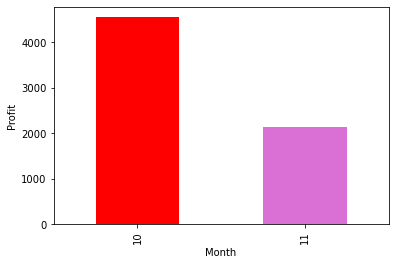

In [105]:
# Reclaiming the maximum amount of available memory
gc.collect()

# Input the name of the brand
print("Please enter the name of the brand to return it's profit for each month.")
brandName = input()
brandedTable = getProfitsPerMonth(brandName)

# Outputting the profits of the given brand for each month
print("The profit for the brand " + brandName + " for each month is the following:")
brandedTable.plot.bar(x='month',y='profit', xlabel='Month', ylabel='Profit', color=['r','orchid']).get_legend().remove()
brandedTable


### [RQ4.2] 
Is the average price of products of different brands significantly different?

The average price of products of different brands vary very much as we can observe from the table and plot below:


,brand,mean_price
1368,pinarello,"2,573.81"
1169,minimotors,"2,258.30"
1429,rado,"2,169.08"
1545,schneider,"2,165.76"
668,fuel,"1,930.55"
...,...,...
685,garnier,1.74
952,kisswill,1.69
810,homeart,1.67
957,kleancolor,1.67


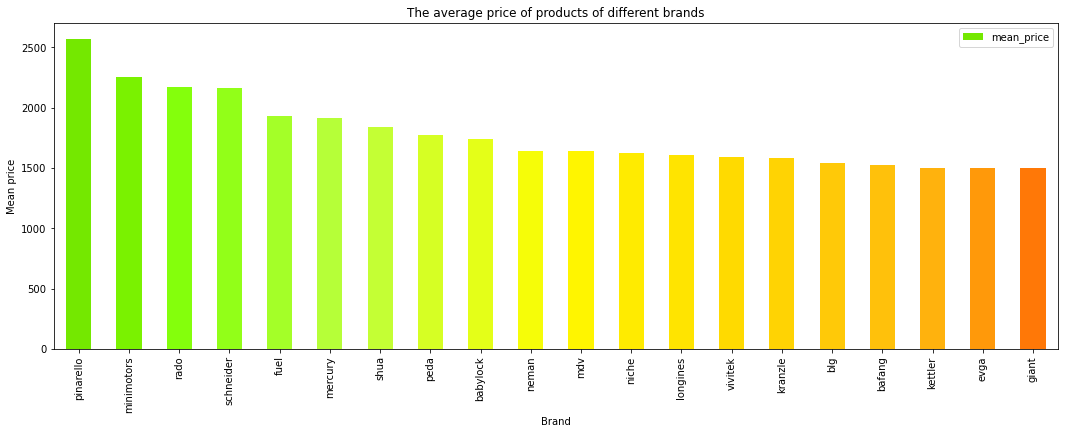

In [106]:
# Reclaiming the maximum amount of available memory
gc.collect()
 
pd.options.display.float_format = '{:,.2f}'.format # Formatting the float values

# Function that returns the mean price for all other brands different from the given one
def getMeanPriceOfOtherBrands(brandName):
    return pd.DataFrame(dataset[dataset.brand != brandName].groupby([dataset.brand]).price.mean()).\
                                                            rename(columns={'price':'mean_price'}). \
                                                            reset_index().sort_values(by = 'mean_price', ascending = False)

# Reclaiming the maximum amount of available memory
gc.collect()

# Calling the function with a given brand name
meanPriceOfBrands = getMeanPriceOfOtherBrands(brandName)
print('The average price of products of different brands vary very much as we can observe from the table and plot below:')

# Reclaiming the maximum amount of available memory
gc.collect()

# Customizing the plot 
color = cm.gist_ncar(np.linspace(.4, .8, 30))
meanPriceOfBrandsPlot = meanPriceOfBrands.head(20).plot.bar(x='brand', y='mean_price', xlabel='Brand', ylabel='Mean price', \
                                                            title='The average price of products of different brands', \
                                                            figsize=(18,6), color=color)
meanPriceOfBrands

### [RQ4.3]
Using the function you just created, find the top 3 brands that have suffered the biggest losses in earnings between one month and the next, specifing both the loss percentage and the 2 months (e.g., brand_1 lost 20% between march and april).

**NOTE!!!**
Since the analyzed data contains only the months October and November we will consider only these months for this exercise.

In [107]:
# Reclaiming the maximum amount of available memory
gc.collect()

# Select only the rows with the selled item and calculate the total profit for each month
totalProfitsPerMonth = dataset[dataset.event_type == 'purchase'].groupby([dataset.brand, dataset.event_time.dt.month]).price.sum()

# Reclaiming the maximum amount of available memory
gc.collect()

# Renaming column of profits and sorting it's values
totalProfitsPerMonth = pd.DataFrame(totalProfitsPerMonth).rename(columns = {'price':'profits'}).reset_index().sort_values(by = 'profits', ascending = False)

# Reclaiming the maximum amount of available memory
gc.collect()

# Renaming column of month 
totalProfitsPerMonth.rename(columns = {'event_time':'month'}, inplace=True)

totalProfitsPerMonth

,brand,month,profits
17,apple,10,"205,297.10"
18,apple,11,"162,477.86"
310,samsung,10,"94,531.16"
311,samsung,11,"71,128.36"
385,xiaomi,10,"16,920.69"
...,...,...,...
340,tarkett,10,5.79
356,transcend,10,5.12
166,ikea,10,4.35
298,ritmix,10,4.25


In [108]:
del brandedTable, brandName, meanPriceOfBrands, color, meanPriceOfBrandsPlot, totalProfitsPerMonth

In [109]:
# Reclaiming the maximum amount of available memory
gc.collect()

# List of unique brands
arrOfBrands = dataset['brand'].dropna().unique().tolist()

# Reclaiming the maximum amount of available memory
gc.collect()

# Dataframe storing all the brands and their losses between October and November
topBrands = pd.DataFrame(columns = ['brand', 'losses_in_earnings'])

# Reclaiming the maximum amount of available memory
gc.collect()

# Iterate per each brand of the dataset
for br in arrOfBrands:
    
    # Call the function getProfitsPerMonth which will return a DataFrame containing the earnings of the brand for each month
    profitsPerMonthOfABrand = getProfitsPerMonth(br)
    
    # Create dictionary for the brand
    dicOfProfitsPerMonth = OrderedDict()
    
    # Iterate for each row of the returned dataframe which contains the earnings of the brand for each month
    for index, row in profitsPerMonthOfABrand.iterrows():
        month = int(row['month'])
        profit = round(row['profit'], 2)
        dicOfProfitsPerMonth[month] = profit

    lossBetweenTwoMonths = 0 
    
    # Controlling of the brand has profits in October and November
    if len(dicOfProfitsPerMonth) == 2:
        lossBetweenTwoMonths = abs(dicOfProfitsPerMonth[11] - dicOfProfitsPerMonth[10]) / dicOfProfitsPerMonth[10]
    # The brand has registered profits only in one of the two months
    else:
        lossBetweenTwoMonths = 100
    
    # Appending a new row contaning the name of the brand and the percentage loss
    topBrands = topBrands.append({'brand': br, 'losses_in_earnings': lossBetweenTwoMonths}, ignore_index = True)

# Reclaiming the maximum amount of available memory
gc.collect()

topBrands.sort_values(by = 'losses_in_earnings', ascending = False, inplace = True)

# Reclaiming the maximum amount of available memory
gc.collect()

# Getting the top three brands with biggest losses in earnings
topThreeBrands = pd.DataFrame(topBrands.head(3))

topThreeBrands

<ipython-input-104-df05777fbd06>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  brandedTable = pd.DataFrame(brandedTable[dataset.event_type == 'purchase'].groupby(dataset.event_time.dt.month).price.sum()).rename(columns={'price':'profit'}).reset_index()


,brand,losses_in_earnings
0,shiseido,100
1330,babygo,100
1298,delmax,100


The brand Shiseido lost 100% between the months October and November.
The brand Babygo lost 100% between the months October and November.
The brand Delmax lost 100% between the months October and November.


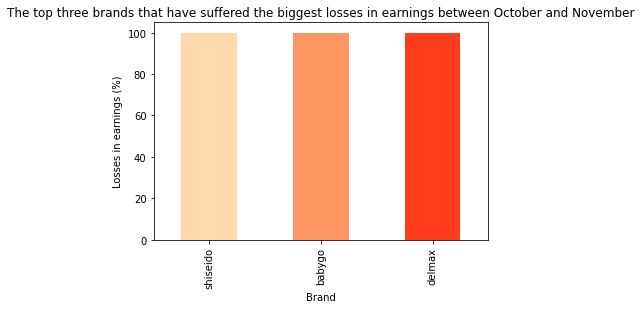

In [110]:
# Reclaiming the maximum amount of available memory
gc.collect()

# Plotting the top three brands that have suffered the biggest losses in earnings between October and November
color = cm.flag(np.linspace(.140, .10, 12))
topThreeBrands.plot.bar(x='brand', y='losses_in_earnings', xlabel='Brand', ylabel='Losses in earnings (%)', \
                        title='The top three brands that have suffered the biggest losses in earnings between October and November',\
                       color=color).get_legend().remove()

# Reclaiming the maximum amount of available memory
gc.collect()

# Printing the top three brands who suffered the biggest losses in earnings
for index, row in topThreeBrands.iterrows():
    print('The brand '+ row['brand'].capitalize() + ' lost ' + str(row['losses_in_earnings']) + '% between the months ' + 'October' + ' and ' + 'November' + '.' )

In [111]:
# Deleting varibles to free RAM
del topThreeBrands, arrOfBrands, topBrands, profitsPerMonthOfABrand, dicOfProfitsPerMonth, month, lossBetweenTwoMonths

# Reclaiming the maximum amount of available memory
gc.collect()

2379

### [RQ6.1] 
The conversion rate of a product is given by the number of times a product has been bought over the number of times it has been visited. What's the conversion rate of your online store? Find the overall conversion rate of your store.

In [14]:
# Reclaiming the maximum amount of available memory
gc.collect()

# The following table shows how many times a product has been purchased.
purchasedProducts = pd.DataFrame(dataset[dataset.event_type == 'purchase'].groupby('product_id').product_id.count()).rename(columns={'product_id':'count purchases'}).reset_index()

# Reclaiming the maximum amount of available memory
gc.collect()

# The following table shows how many times a product has been viewed.
viewedProducts = pd.DataFrame(dataset[dataset.event_type == 'view'].groupby('product_id').product_id.count()).rename(columns={'product_id':'count views'}).reset_index()

# Reclaiming the maximum amount of available memory
gc.collect()

# Join on the two tables
mergedTable = purchasedProducts.join(viewedProducts.set_index('product_id'), on = 'product_id')

# Reclaiming the maximum amount of available memory
gc.collect()

# Add a new column to the table and calculate the conversion rate for each product
mergedTable['conversion rate'] = mergedTable['count purchases']/mergedTable['count views']

# Calculate the overall conversion rate of the store
print('The overall conversion rate of the store is equal to: ' + str(round(mergedTable['conversion rate'].mean(),2)) + '%.')

del purchasedProducts, viewedProducts, mergedTable

The overall conversion rate of the store is equal to: 0.16%.


### [RQ6.2] 
Plot the number of purchases of each category and show the conversion rate of each category in decreasing order.

**NOTE!!!**
For a simple resolution of these exercises we are considering the column *category_id* because it always contains a value (it has no Nan values).

Below we can view both the table, for a better understanding, and the plot of the number of purchases of each category:


,category_id,count_purchases
0,2053013552259662037,17
1,2053013552293216471,13
2,2053013552326770905,12
3,2053013552351936731,2
4,2053013552385491165,6
...,...,...
220,2146551843914777018,1
221,2146660887002349890,1
222,2151563850841850061,1
223,2164367422893589471,2


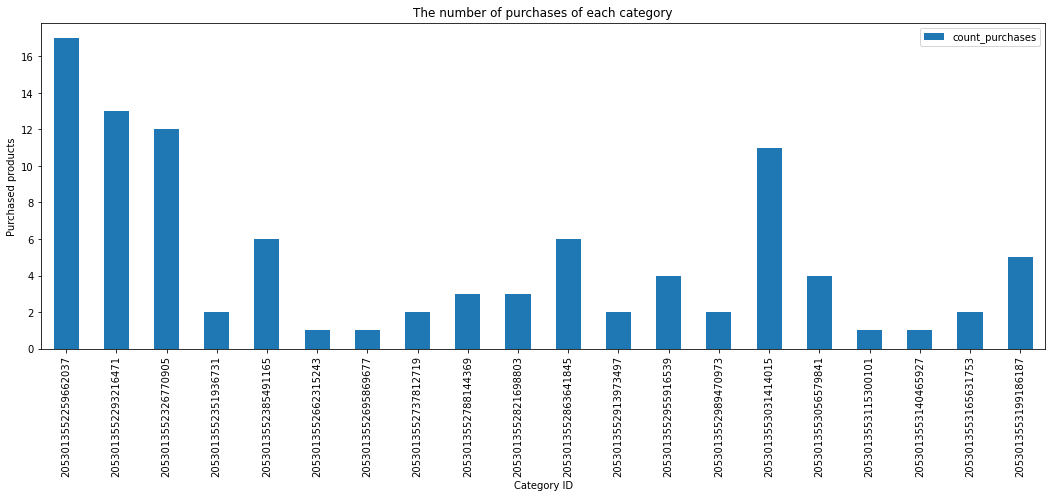

In [16]:
# Reclaiming the maximum amount of available memory
gc.collect()

# The following table shows how many times a product has been purchased for each category
print("Below we can view both the table, for a better understanding, and the plot of the number of purchases of each category:")

# Reclaiming the maximum amount of available memory
gc.collect()

# Selectiong the rows that contain the purchased products and group them by category_id in order to count for each category the number of selled products
purchasedProducts = pd.DataFrame(dataset[dataset.event_type == 'purchase'].groupby('category_id').product_id.count()).rename(columns={'product_id':'count_purchases'}).reset_index()

# Reclaiming the maximum amount of available memory
gc.collect()

# Plotting the table above
purchasedProductsPlot = purchasedProducts.head(20).plot.bar(x = 'category_id', y = 'count_purchases', figsize=(18,6), xlabel = 'Category ID', ylabel = 'Purchased products', title= "The number of purchases of each category")

purchasedProducts

The conversion rate for each product category in decreasing order can be viewed in the table and plot below:


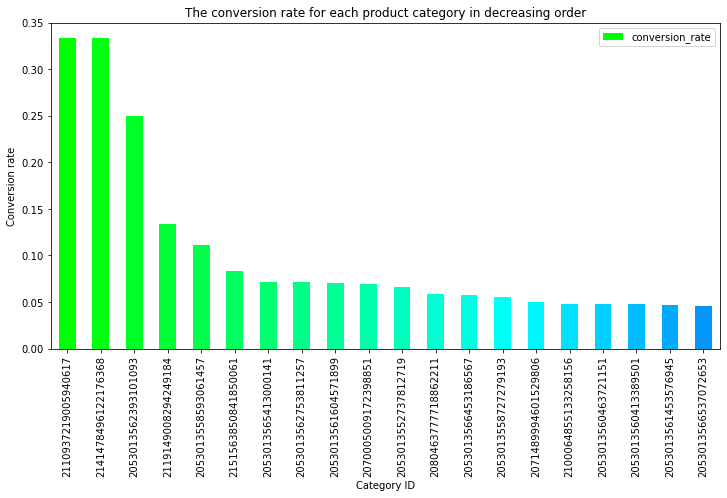

In [17]:
# Reclaiming the maximum amount of available memory
gc.collect()

# Reclaiming the maximum amount of available memory
gc.collect()

# The following table shows how many times a product has been viewed for each category
viewedProducts = pd.DataFrame(dataset[dataset.event_type == 'view'].groupby('category_id').product_id.count()).rename(columns={'product_id':'count_views'}).reset_index()

# Reclaiming the maximum amount of available memory
gc.collect()

# Join on the two tables
mergedTable = purchasedProducts.join(viewedProducts.set_index('category_id'), on = 'category_id')

# Reclaiming the maximum amount of available memory
gc.collect()

# Add a new column to the table and calculate the conversion rate for each product category in decreasing order
mergedTable['conversion_rate'] = mergedTable['count_purchases']/mergedTable['count_views']
pd.options.display.float_format = '{:,.2f}'.format
mergedTable = mergedTable.sort_values(by = 'conversion_rate', ascending = False)
print('The conversion rate for each product category in decreasing order can be viewed in the table and plot below:')

# Reclaiming the maximum amount of available memory
gc.collect()

# Customizing the plot
color = cm.gist_rainbow(np.linspace(.4, .8, 30))
conversionRatePlot = mergedTable.head(20).plot.bar(x = 'category_id', xlabel = "Category ID", y = "conversion_rate", ylabel = "Conversion rate", figsize = (12,6), color=color, title='The conversion rate for each product category in decreasing order')

In [18]:
# Deleting unused variables of the previous cells
del purchasedProducts, purchasedProductsPlot, viewedProducts, mergedTable, conversionRatePlot

# Reclaiming the maximum amount of available memory
gc.collect()

9122